# Getting started with ACED-HMM trained with ABC-MCMC

This notebook introduces users to all the major functionalities of the repository, by walking through a full example of training ACED-HMM via our ABC-MCMC training procedure.

In this example, we will work with census counts from the state of Washington, with training window Nov. 11 - Jan. 10 and testing window Jan. 11 - Feb. 11. After familiarizing with this example, we invite users to try out the pipeline with a different state and with different training/testing windows (note: the training and testing windws are adjacent); all that needs to be done is modifying the directory paths in each cell to reflect the desired state and windows.

# 0. Generate US state-level dataset using our data collection and data preparation scripts

Our data collection pipeline combines counts from the University of Minnesota and from the HHS.

The data preparation step generates a new folder with 3 files:
- config.json: config file with information necessary to fit the model on this data via ABC
- daily_admissions.csv: containing per-day admissions for the specified state and during the specified time period (start_date to end_date)
- daily_counts.csv: containing per-day census counts for the specified state and during the specified time period (start_date to end_date)

These three files alone are needed to fit the model via ABC. \
The name of the folder follows the following pattern: {{state}}-{{start_date}}-{{end_training_date}}-{{end_date}}

In [32]:
%%bash
cd datasets/US
python3 generate_data_US.py --state MA --start_date 20201111 --end_training_date 20210111 --end_date 20210211

DOWNLOADING FRESH HHS DATA.........
DOWNLOADING FRESH COVIDTRACKING DATA.........
19743 admitted patients in this timeframe


# 1. Fit posterior of ACED-HMM parameters via ABC

Use default annealing schedule and prior; please see the script to see all the default parameters. Since this is only a demonstration, for the sake of time we only train for 100 iterations, which does not achieve convergence. With our default annealing schedule, we recommend 32,000 iterations to reach convergence, which, depending upon dataset and hardware capabilities, usually takes a few hours.

We emphasize the use of the argument 'approximate' which defines how many patients are to be modeled at the same time (i.e. using a single trajectory). Setting a higher value reduces the granularity of the trajectory and increases uncertainty, but it speeds-up generating trajectories by N-folds.

In [1]:
seed = 1980

In [25]:
%%bash 
# for the SMC extension update algorithm = smc, num_iterations to 50, and num_samples_to_save to 1
python -m aced_hmm.fit_posterior_with_abc_dlh \
    --input_dir datasets/US/SD-20201111-20210111-20210211 \
    --output_dir results/US/SD-20201111-20210111-20210211/full_abc3 \
    --approximate 5 \
    --num_iterations 32000 \
    --start_epsilon 0.7 \
    --num_samples_to_save 200 \
    --random_seed $(($seed)) \
    --algorithm abc


100%|██████████| 32000/32000 [57:49<00:00,  9.22it/s]    


Elapsed time with python on 32000 iterations:  3469.241 sec


# 2. Visualize prior and posterior distributions over ACED-HMM's parameters

In [11]:
from aced_hmm.visualize_forecasts import plot_params

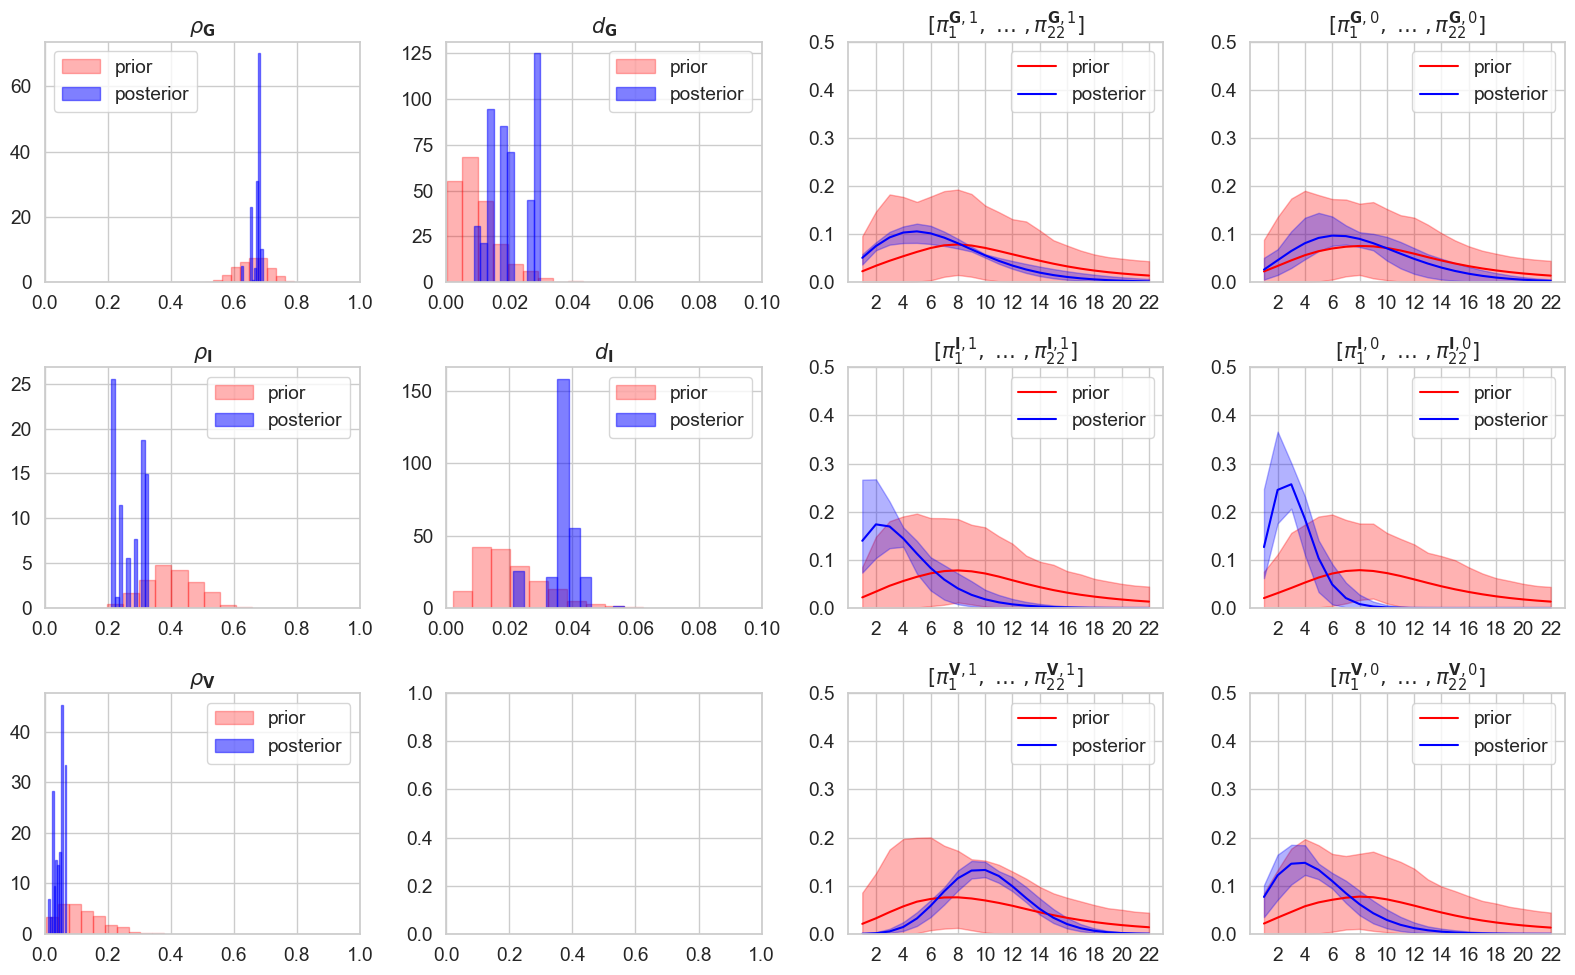

In [30]:
samples_path = 'results/US/SD-20201111-20210111-20210211/full_abc3/posterior_samples.json'

## Other default parameters
#
# filename_prior='priors/abc_prior_config_OnCDCTableReasonable.json' --> our prior based on CDC data
# filename_to_save=None --> currently not saving the plot(s)
# filename_true_params=None --> only provided if true parameters are known (used in experiments with synthetic data)
# plot_disjointly=False --> currently plotting the parameters in one big plot, as opposed to each parameter in one plot
#                           If False, then 'filename_to_save' must be a full file path, such as 'MA_parameters.pdf'
#                           If True, then 'filename_to_save' must be just a template, which is then completed by the
#                               code with the parameter name. For example, if specifying 'MA_parameters', the plots are
#                               saved as 'MA_parameters_proba_Recovering_InGeneralWard.pdf', etc.

plot_params(samples_path)

# 3. Run forecast with "fitted" posterior

The script `run_forecast` runs a single forecast for every sample from the posterior distribution of ACED-HMM parameters. Each forecast is also run with a different random seed, in increasing order from the provided value of random_seed. The user can specify how many samples to consider; providing 'None' uses all the samples.

If `run_forecast` is provided a single value for each parameter, as opposed to a list of samples, the script runs num_seeds forecasts each with the same, provided parameters. If num_seeds is 'None', only one forecast is made.

Again, notice the 'approximate' argument. Try increasing it - you should notice a reduction in runtime, and higher uncertainty in the forecasts at step 5.

In [26]:
%%bash
# full abc forecast

python -m aced_hmm.run_forecast \
    --func_name python \
    --config_path results/US/SD-20201111-20210111-20210211/full_abc3/config_after_abc.json \
    --output_dir results/US/SD-20201111-20210111-20210211/individual_forecasts/full_abc3 \
    --output_file results_after_abc-{{random_seed}}.csv \
    --approximate 5 \
    --random_seed $(($seed)) \
    --num_seeds None

results/US/SD-20201111-20210111-20210211/full_abc3/config_after_abc.json
Forecasting from samples ...
Using 200 parameter samples, each with a distinct random seed.
--------------------------------------------
           Running 200 simulations
--------------------------------------------


100%|██████████| 200/200 [00:01<00:00, 149.67it/s]


# 4. Summarize forecasts

#### Run this if on Linux / MAC-OS

In [27]:
%%bash
python -m aced_hmm.summarize_forecasts --input_dir results/US/SD-20201111-20210111-20210211/individual_forecasts/full_abc3 \
                                       --output_dir results/US/SD-20201111-20210111-20210211/full_abc3 \
                                       --output_template summary_after_abc_ \
                                       --input_csv_file_pattern results_after_abc*.csv \
                                       --comma_sep_percentiles 1,2.5,5,10,25,50,75,90,95,97.5,99

----------------------------------------
Reading in data from 200 simulations
----------------------------------------


100%|██████████| 200/200 [00:00<00:00, 2003.09it/s]


----------------------------------------
Computing summaries for 11 percentiles
----------------------------------------


# 5. Visualize forecasts

In [20]:
from aced_hmm.visualize_forecasts import plot_forecasts

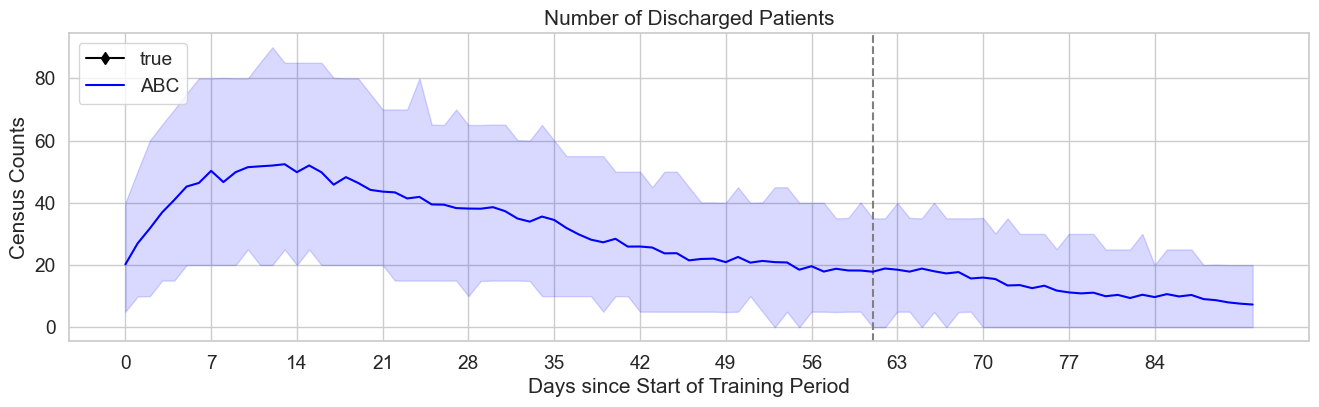

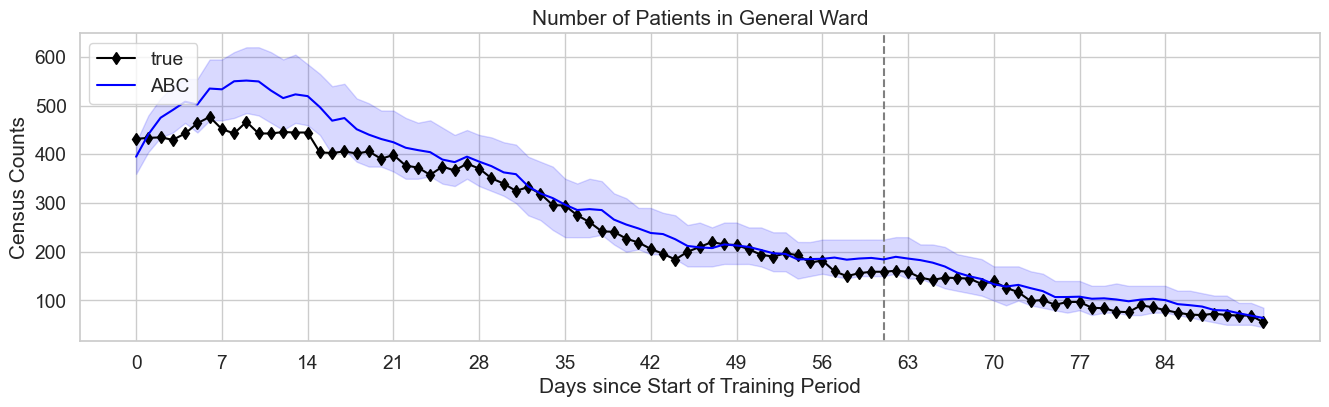

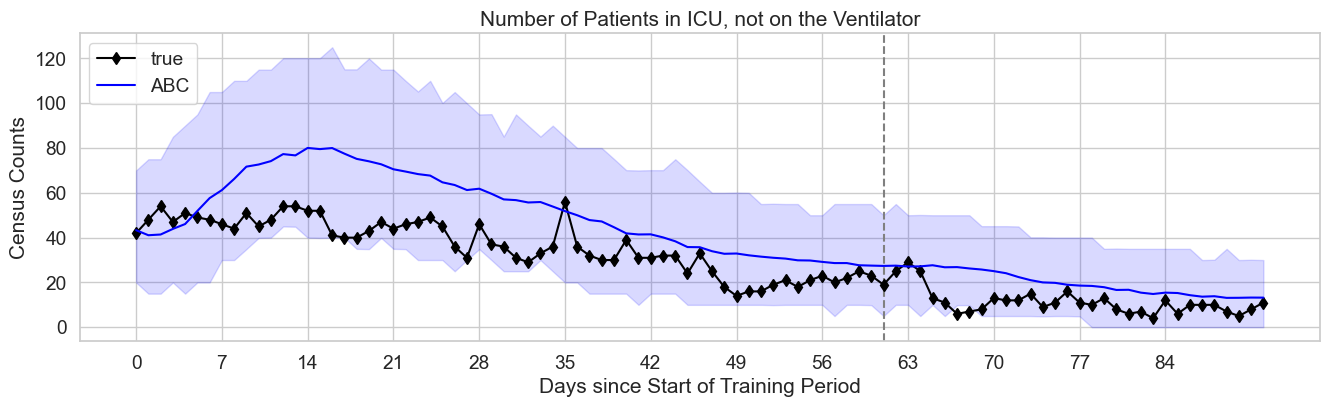

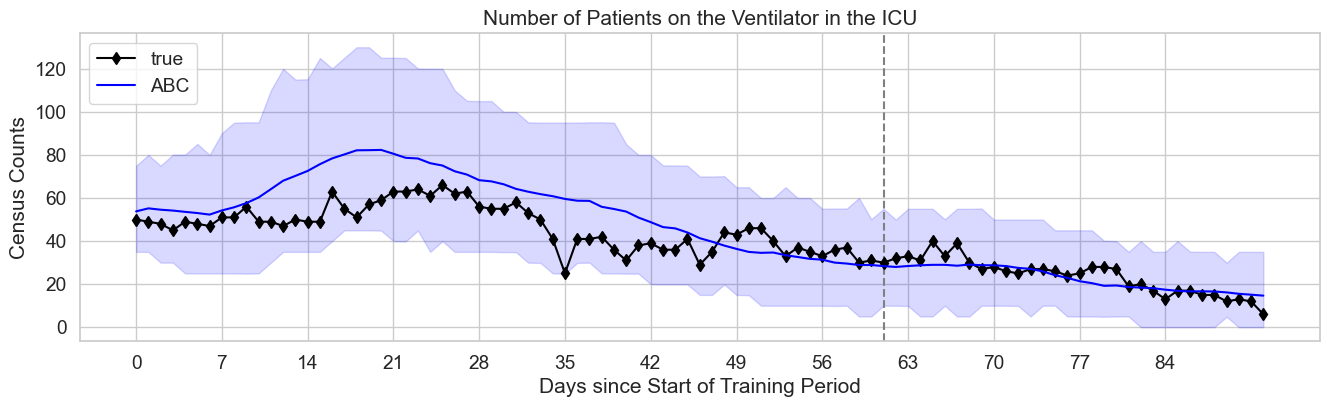

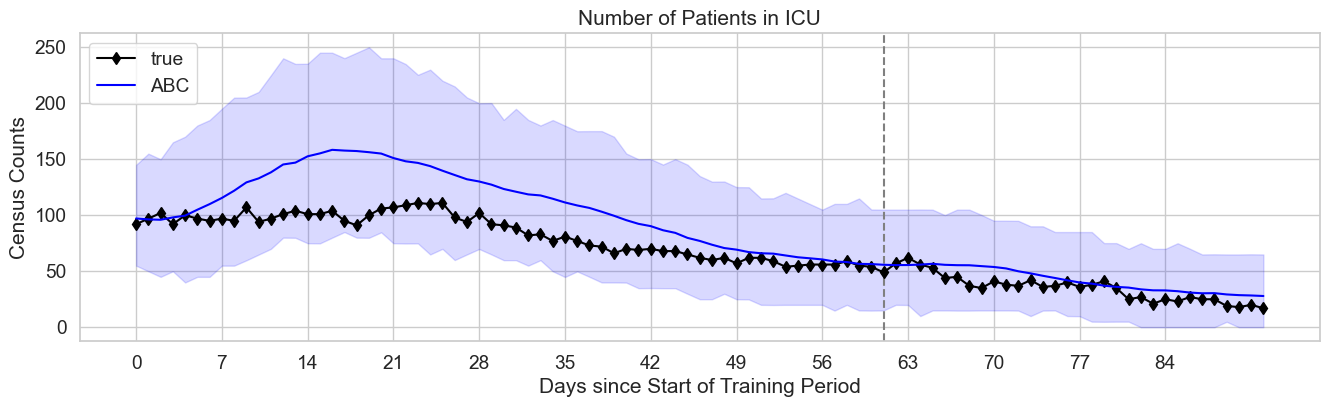

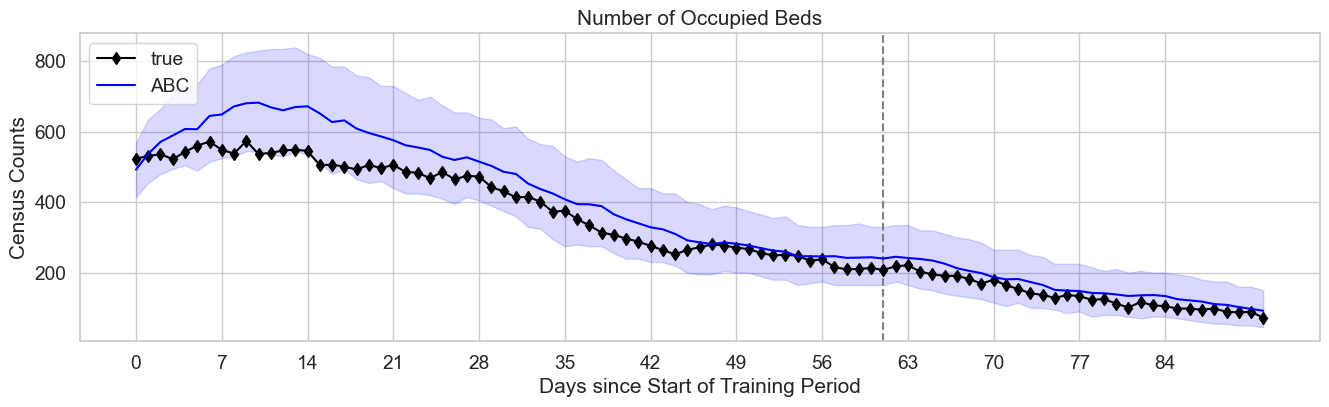

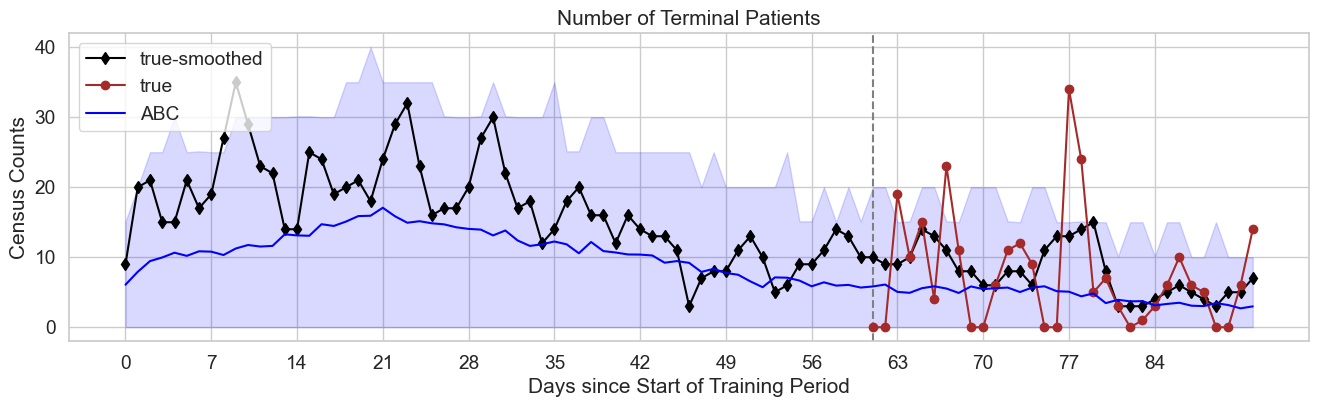

In [28]:
config_path = 'results/US/SD-20201111-20210111-20210211/full_abc3/config_after_abc.json'
input_summaries_template_path = 'results/US/SD-20201111-20210111-20210211/full_abc3/summary_after_abc'
true_stats = 'datasets/US/SD-20201111-20210111-20210211/daily_counts.csv'

## Other default parameters
#
# figure_template_path=None --> currently not saving the plots. Must provide a template, which the code completes with the 
#                                   count name. For example, specifying 'MA_forecasts' saves the plots with names 
#                                   'MA_forecast_n_InGeneralWard.pdf', etc.
# smooth_terminal_counts=True --> plots smoothed version of true terminal counts (n_TERMINAL_5daysSmoothed)
# expected_columns=['n_discharged_InGeneralWard', 'n_InGeneralWard', 'n_OffVentInICU', 'n_OnVentInICU', 'n_InICU', 'n_occupied_beds', 'n_TERMINAL']
#                  --> counts to plot forecasts for

plot_forecasts(input_summaries_template_path, config_path, true_stats)

In [29]:
from aced_hmm.print_stats import get_method_stats
# For ACED-HMM + ABC
abc_stats = get_method_stats(
    "ACED-HMM + ABC", 
    "results/US/SD-20201111-20210111-20210211/full_abc3/summary_after_abc",
    "results/US/SD-20201111-20210111-20210211/full_abc3/config_after_abc.json",
    "datasets/US/SD-20201111-20210111-20210211/daily_counts.csv"
)

# Display results
print("Statistics for ACED-HMM + ABC:")
abc_stats

Statistics for ACED-HMM + ABC:


MAE           CI
Method         State                             
ACED-HMM + ABC G InGeneralWard  16.2  13.2 - 19.3
               I + V InICU       8.0    6.2 - 9.8
               V OnVentInICU     3.4    2.4 - 4.6
               T sm. Death       6.2    4.3 - 8.4